In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [2]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Distribution plot funciton
def distri_plot(df):
    f, axes = plt.subplots(3, 3, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        ## jump to plotting energy
        if(col_name == "rain"):
            sns.distplot(df["energy"],ax=axes[2,2])
            return
        sns.distplot(df[col_name],ax=axes[idx//3,idx%3])  
    ## plot     
    plt.tight_layout()

## Scatter plot function
def scatter_plot(df):
    f, axes = plt.subplots(4, 2, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= 8):
            return
        ## jump to plotting energy
        sns.scatterplot(x= col_name,y = "energy", data = df, ax=axes[idx//2,idx%2])  
    ## plot     
    plt.tight_layout()


## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}_{}".format(name,i), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat, multioutput = "variance_weighted")))
    

In [3]:
train = pd.read_csv("../data/train_nocat.csv")
test = pd.read_csv("../data/test_nocat.csv")

In [4]:
train = train.set_index("Unnamed: 0")
test = test.set_index("Unnamed: 0")

### Creat lag ahead scenarios

In [5]:
#create 48 hours recency effect matrix
ahead_w = lag_ahead_series(train.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)

#create 48 housrs ahead energy consumption matrix
ahead_e = lag_ahead_series(train.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)

ahead_w.shape, ahead_e.shape

((13991, 392), (13991, 49))

In [6]:
#create 48 hours recency effect matrix
ahead_wt = lag_ahead_series(test.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)

#create 48 housrs ahead energy consumption matrix
ahead_et = lag_ahead_series(test.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)

ahead_wt.shape, ahead_et.shape

((5775, 392), (5775, 49))

## Autosklearn

In [12]:
import autosklearn.regression as autoreg
y_pred = pd.DataFrame()
cls_list = []
for i in range(49):
    cls = autoreg.AutoSklearnRegressor(time_left_for_this_task=400, 
                                       per_run_time_limit=180, 
                                       initial_configurations_via_metalearning=0,
                                       ensemble_size=50, 
                                       ensemble_nbest=25, 
                                       ensemble_memory_limit=1024, 
                                       seed=1, ml_memory_limit=4096, 
                                       include_estimators= None, 
                                       exclude_estimators=None, 
                                       include_preprocessors=None, 
                                       exclude_preprocessors=None, 
                                       resampling_strategy='holdout', 
                                       resampling_strategy_arguments={'train_size':0.7,
                                                                      'shuffle':True}, 
                                       tmp_folder=None, 
                                       output_folder=None, 
                                       delete_tmp_folder_after_terminate=True, 
                                       delete_output_folder_after_terminate=True, 
                                       shared_mode=False, 
                                       n_jobs = 8, 
                                       disable_evaluator_output=False, 
                                       get_smac_object_callback=None, 
                                       smac_scenario_args=None, 
                                       logging_config=None, 
                                       metadata_directory=None)

    cls.fit(ahead_w.iloc[:,:392], ahead_e.iloc[:,i:i+1])
    y_pred = pd.concat([y_pred, pd.DataFrame(cls.predict(ahead_wt.iloc[:5,:392]))], axis = 1)


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 20:32:29,166:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:32:29,172:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:32:31,177:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:32:33,181:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:32:35,186:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:32:37,189:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:32:39,193:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

[WARNING] [2020-03-19 20:34:19,920:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:34:21,933:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:34:23,938:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:34:25,952:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:34:27,968:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:34:29,974:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:34:31,980:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 20:39:04,228:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:39:04,235:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:39:06,241:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:39:08,260:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:39:10,278:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:39:12,292:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 20:45:39,971:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:45:39,977:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:45:41,984:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:45:44,001:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:45:46,014:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:45:48,033:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:45:50,048:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 20:52:17,684:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:52:17,713:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:52:19,738:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:52:21,748:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:52:23,772:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 20:58:52,827:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:58:52,834:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:58:54,842:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:58:56,850:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:58:58,854:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:59:00,870:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 20:59:02,882:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 21:05:29,386:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:05:29,411:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:05:31,417:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:05:33,434:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:05:35,445:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:05:37,450:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:05:39,461:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 21:12:05,619:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:12:05,635:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:12:07,642:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:12:09,654:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:12:11,678:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:12:13,692:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:12:15,705:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 21:18:40,333:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:18:40,340:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:18:42,348:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:18:44,377:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:18:46,390:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:18:48,398:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 21:25:16,816:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:25:16,823:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:25:18,829:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:25:20,838:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:25:22,861:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:25:24,868:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:25:26,874:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 21:31:51,393:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:31:51,402:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:31:53,408:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:31:55,414:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:31:57,426:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:31:59,441:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:32:01,446:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 21:38:27,888:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:38:27,899:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:38:29,902:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:38:31,913:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:38:33,922:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:38:35,940:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:38:37,957:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 21:45:02,822:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:45:02,827:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:45:04,833:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:45:06,840:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:45:08,862:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:45:10,877:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:45:12,889:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 21:51:39,946:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:51:39,979:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:51:42,006:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:51:44,014:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:51:46,020:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:51:48,026:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 21:58:14,254:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:58:14,260:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:58:16,267:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:58:18,286:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:58:20,297:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 21:58:22,306:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 22:04:51,429:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:04:51,502:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:04:53,518:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:04:55,525:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:04:57,545:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 22:11:26,001:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:11:26,008:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:11:28,015:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:11:30,020:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:11:32,042:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:11:34,054:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:11:36,077:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

Process pynisher function call:
Traceback (most recent call last):
  File "/home/charles/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/charles/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/charles/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 129, in subprocess_func
    for child in p.children(recursive=True):
  File "/home/charles/anaconda3/lib/python3.7/site-packages/psutil/__init__.py", line 392, in wrapper
    return fun(self, *args, **kwargs)
  File "/home/charles/anaconda3/lib/python3.7/site-packages/psutil/__init__.py", line 1015, in children
    ppid_map = _ppid_map()
  File "/home/charles/anaconda3/lib/python3.7/site-packages/psutil/_pslinux.py", line 1492, in ppid_map
    data = f.read()
  File "/home/charles/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 31, in handler
    r

[WARNING] [2020-03-19 22:18:01,709:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:18:01,714:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:18:03,722:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:18:05,738:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:18:07,766:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:18:09,781:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:18:11,794:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 22:24:37,499:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:24:37,506:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:24:39,513:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:24:41,538:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:24:43,545:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:24:45,557:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:24:47,567:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 22:31:15,166:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:31:15,191:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:31:17,215:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:31:19,222:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:31:21,229:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:37:43,839:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2020-03-19 22:37:43,839:smac.intensification.intensification.Intensifier] Challenger was the same a

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 22:37:49,936:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:37:49,974:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:37:51,993:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:37:54,002:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:37:56,020:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 22:44:24,686:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:44:24,691:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:44:26,697:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:44:28,717:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:44:30,726:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:44:32,745:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:44:34,750:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 22:51:00,758:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:51:00,771:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:51:02,776:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:51:04,782:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:51:06,797:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:51:08,806:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:51:10,817:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 22:57:38,376:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:57:38,396:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:57:40,427:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:57:42,442:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:57:44,461:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:57:46,469:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 22:57:48,478:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 23:04:12,931:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:04:12,937:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:04:14,944:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:04:16,966:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:04:18,981:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:04:21,013:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:04:23,021:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 23:10:50,033:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:10:50,057:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:10:52,077:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:10:54,105:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 23:17:26,524:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:17:26,556:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:17:28,562:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:17:30,582:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:17:32,588:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:17:34,608:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:17:36,617:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 23:24:01,814:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:24:01,831:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:24:03,834:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:24:05,849:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:24:07,869:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:24:09,880:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 23:30:37,452:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:30:37,457:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:30:39,464:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:30:41,472:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:30:43,493:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:30:45,516:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:30:47,540:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 23:37:13,191:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:37:13,196:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:37:15,203:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:37:17,210:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:37:19,216:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:37:21,226:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:37:23,241:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 23:43:49,215:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:43:49,221:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:43:51,227:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:43:53,241:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:43:55,254:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:43:57,276:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:43:59,305:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

Process Process-770:
Traceback (most recent call last):
  File "/home/charles/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/charles/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 1091, in fit
    load_models=load_models,
  File "/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 489, in _fit
    _proc_smac.run_smbo()
  File "/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/smbo.py", line 513, in 

[WARNING] [2020-03-19 23:50:25,134:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:50:25,140:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:50:27,147:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:50:29,162:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:50:31,173:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:50:33,190:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:50:35,212:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 23:57:01,259:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:57:01,265:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:57:03,274:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:57:05,286:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:57:07,310:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:57:09,337:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 23:57:11,358:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 00:03:37,923:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:03:37,932:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:03:39,946:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:03:41,972:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:03:43,981:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 00:10:15,028:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:10:15,049:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:10:17,061:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:10:19,069:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:10:21,078:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:10:23,085:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 00:16:49,532:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:16:49,537:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:16:51,543:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:16:53,550:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:16:55,561:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:16:57,566:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:16:59,578:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 00:23:24,379:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:23:24,386:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:23:26,392:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:23:28,410:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:23:30,417:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:23:32,429:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 00:30:01,657:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:30:01,667:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:30:03,673:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:30:05,700:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:30:07,710:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:30:09,716:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


Traceback (most recent call last):
  File "/home/charles/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/home/charles/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/charles/anaconda3/lib/python3.7/multiprocessing/queues.py", line 192, in _finalize_join
    thread.join()
  File "/home/charles/anaconda3/lib/python3.7/threading.py", line 1032, in join
    self._wait_for_tstate_lock()
  File "/home/charles/anaconda3/lib/python3.7/threading.py", line 1048, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/home/charles/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 31, in handler
    raise(TimeoutException)
pynisher.limit_function_call.TimeoutException
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d ar

[WARNING] [2020-03-20 00:36:35,179:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:36:35,183:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:36:37,189:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:36:39,194:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:36:41,213:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:36:43,222:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:36:45,230:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 00:43:11,861:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:43:11,871:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:43:13,882:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:43:15,893:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:43:17,906:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 00:49:46,326:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:49:46,332:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:49:48,341:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:49:50,365:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:49:52,390:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:49:54,405:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:49:56,433:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 00:56:22,761:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:56:22,772:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:56:24,777:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:56:26,788:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:56:28,806:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 00:56:30,817:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 01:02:58,544:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:02:58,565:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:03:00,579:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:03:02,598:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:03:04,614:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 01:09:34,297:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:09:34,309:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:09:36,326:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:09:38,345:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:09:40,361:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 01:16:10,319:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:16:10,348:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:16:12,377:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:16:14,394:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:16:16,402:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:16:18,418:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:16:20,426:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 01:22:45,669:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:22:45,678:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:22:47,682:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:22:49,709:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:22:51,718:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:22:53,733:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:22:55,750:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 01:29:20,566:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:29:20,571:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:29:22,577:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:29:24,585:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:29:26,593:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:29:28,598:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:29:30,613:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 01:35:56,522:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:35:56,529:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:35:58,536:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:36:00,560:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:36:02,582:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:36:04,605:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:36:06,616:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 01:42:32,373:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:42:32,378:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:42:34,386:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:42:36,393:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:42:38,406:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:42:40,426:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:42:42,448:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than

/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-20 01:49:08,959:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:49:08,965:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:49:10,970:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:49:12,998:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:49:15,010:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!
[WARNING] [2020-03-20 01:49:17,036:EnsembleBuilder(1791095845):28bee70f51bbda319d151e96d8f7d1a7] No models better than random - using Dummy Score!


**Metrics**

In [14]:
observed = np.transpose(ahead_et.iloc[:5,:].to_numpy())
prediction = np.transpose(y_pred.to_numpy())
get_eval(observed, prediction)

MSE: 0.001163068372677454
MAE: 0.025778677429942422
r2_score: 0.8452035102149807


In [15]:
observed.shape, prediction.shape

((49, 5), (49, 5))

**Visualization**

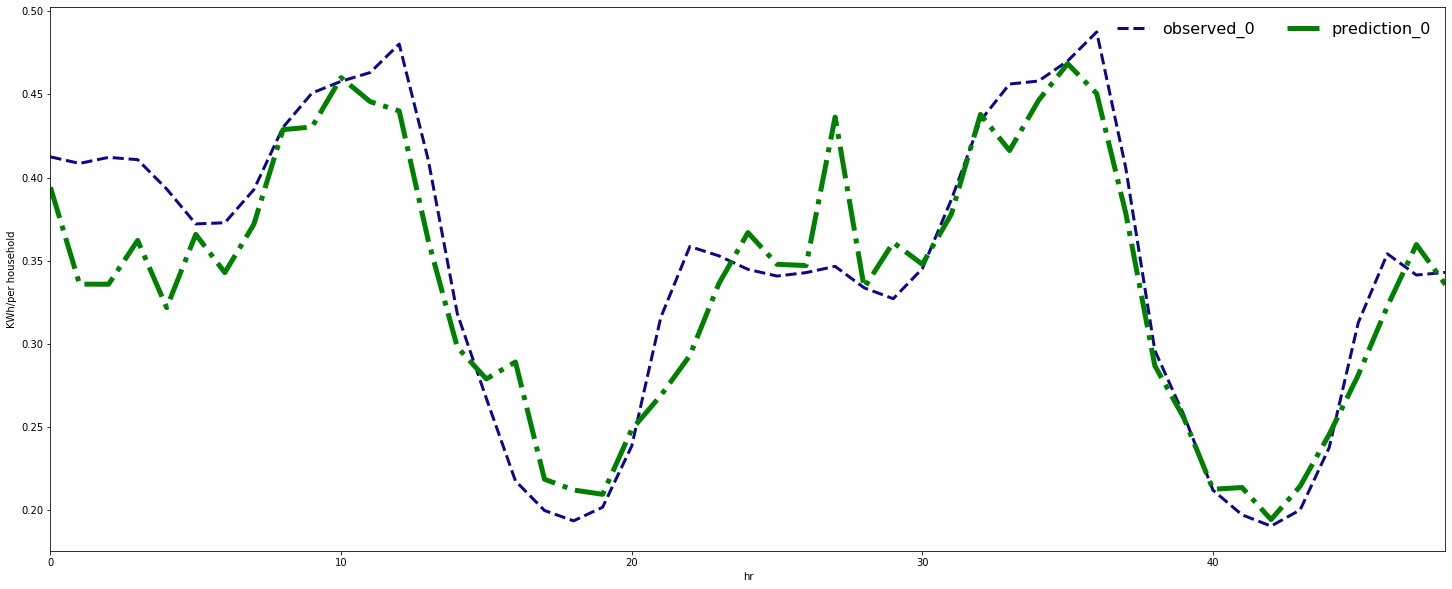

In [30]:
## assignment.
real = ahead_et.iloc[1:2,:].to_numpy()
guess = y_pred.iloc[1:2,:].to_numpy()

rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()

rpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw= 3)
gpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax, lw= 5)

ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

In [22]:
cls.get_models_with_weights()

[(0.78,
  SimpleRegressionPipeline({'categorical_encoding:__choice__': 'no_encoding', 'imputation:strategy': 'median', 'preprocessor:__choice__': 'extra_trees_preproc_for_regression', 'regressor:__choice__': 'k_nearest_neighbors', 'rescaling:__choice__': 'none', 'preprocessor:extra_trees_preproc_for_regression:bootstrap': 'False', 'preprocessor:extra_trees_preproc_for_regression:criterion': 'mse', 'preprocessor:extra_trees_preproc_for_regression:max_depth': 'None', 'preprocessor:extra_trees_preproc_for_regression:max_features': 0.3931799900554185, 'preprocessor:extra_trees_preproc_for_regression:max_leaf_nodes': 'None', 'preprocessor:extra_trees_preproc_for_regression:min_samples_leaf': 15, 'preprocessor:extra_trees_preproc_for_regression:min_samples_split': 15, 'preprocessor:extra_trees_preproc_for_regression:min_weight_fraction_leaf': 0.0, 'preprocessor:extra_trees_preproc_for_regression:n_estimators': 100, 'regressor:k_nearest_neighbors:n_neighbors': 3, 'regressor:k_nearest_neighbor